# Tutorial

In [ ]:
# Install or upgrade required dependencies
!pip install typing-extensions>=4.7.0 transformers==4.25.1 datasets==2.10.1 torch==1.13.1 wandb==0.15.0 --upgrade

# Restart the kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'status': 'ok', 'restart': True}

: 

## Import the necessary Packages

In [1]:
# used in the previous experiments
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer

# for training
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer

# for experiment tracking
import wandb


# common packages
import pandas as pd
from pprint import pprint
import json
import numpy as np
from matplotlib import pyplot as plt

/home/sachin/miniconda3/envs/lmlf/lib/python3.10/site-packages/wandb/apis/public.py:3109: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


# 1.

In [4]:
ds_full = load_dataset('Yelp/yelp_review_full')
pprint(ds_full)

ValueError: Invalid pattern: '**' can only be an entire path component

## Merging

In [ ]:
from datasets import concatenate_datasets

In [ ]:
# Merge the train and test datasets
from datasets import concatenate_datasets
ds_merged = concatenate_datasets([ds_full['train'], ds_full['test']])
ds_merged

Dataset({
    features: ['text', 'label'],
    num_rows: 8
})

## Count the total words

In [ ]:
# first statement is false
sum(len(example['text'].split()) for example in ds_merged)

In [ ]:
# Check the second statement
# apply filter
ds_single_word = ds_merged.filter(lambda example: len(example['text'].split())==1)
ds_single_word

Filter: 100%|██████████| 700000/700000 [00:09<00:00, 72036.93 examples/s]


Dataset({
    features: ['label', 'text'],
    num_rows: 355
})

In [ ]:
# Average
93878307/700000

134.11186714285714

## Distribution of the length of the samples

In [ ]:
# Calculate the length of each sample (number of words per sample)
sample_lengths = [len(text.split()) for text in ds_merged['text']]
sample_lengths.sort()

In [ ]:
bins = np.unique(sample_lengths)

In [ ]:
len(sample_lengths)

700000

In [ ]:
bins

array([   1,    2,    3, ..., 1025, 1034, 1052], shape=(1006,))

In [ ]:
len(bins)

1006

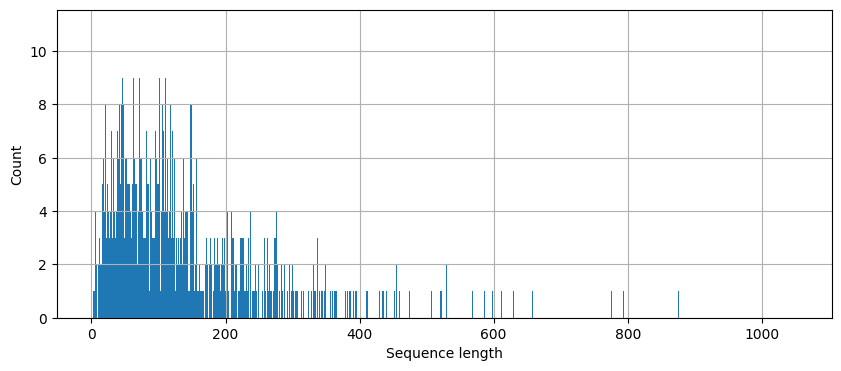

In [ ]:
# Plot the distribution
import random
plt.figure(figsize=(10, 4))
plt.hist(random.sample(sample_lengths, k=10**3), bins=bins[:])
plt.xlabel('Sequence length')
plt.ylabel('Count')
plt.grid()
plt.show()

# 2.

## Load the tokenizer

In [ ]:
# Load the tokenizer and test it
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
print(tokenizer)

# Test tokenizing a sample from our dataset
sample_text = ds_merged['text'][0]
tokens = tokenizer(sample_text, return_tensors='pt')
print("\nSample text:", sample_text)
print("Tokenized:", tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]))

/home/sachin/miniconda3/envs/lmlf/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Sample text: This is a positive review. I loved it.
Tokenized: ['[CLS]', 'this', 'is', 'a', 'positive', 'review', '.', 'i', 'loved', 'it', '.', '[SEP]']


In [ ]:
tokenizer.model_max_length  # 512


512

In [ ]:
tokenizer.special_tokens_map


{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
# Select a sample more than 512 words
sample_512 = ds_merged.filter(lambda example: len(example['text'].split())>512)
sample_512

Filter: 100%|██████████| 700000/700000 [00:10<00:00, 67553.93 examples/s]


Dataset({
    features: ['label', 'text'],
    num_rows: 12441
})

In [ ]:
tokenize_sample = tokenizer(sample_512['text'][0])
tokenize_sample

Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': [101, 2044, 1037, 2851, 1997, 16215, 16338, 3573, 5933, 1010, 1037, 2767, 1998, 1045, 2020, 3241, 1997, 6265, 1010, 1998, 2002, 4081, 16243, 1005, 1055, 2044, 2002, 1005, 1040, 2464, 3782, 7367, 3676, 2243, 2079, 1037, 2978, 2006, 2009, 1998, 2018, 2699, 2009, 1037, 2051, 2030, 2048, 2077, 1010, 1998, 1045, 2018, 2025, 1012, 2002, 2056, 2027, 2018, 1037, 11519, 17294, 1010, 2021, 2000, 2022, 4810, 2000, 3357, 2067, 1999, 2051, 1012, 1032, 1050, 1032, 22064, 5349, 1010, 3773, 2004, 2129, 1045, 1005, 1049, 2785, 1997, 23042, 2000, 2397, 2871, 1005, 1055, 1998, 2220, 2753, 1005, 1055, 1010, 1998, 1996, 2878, 9350, 5308, 3496, 1010, 9085, 2067, 1999, 2051, 2003, 1037, 10979, 2689, 1999, 4830, 20934, 27172, 1012, 1012, 1012, 2004, 2146, 2004, 2009, 2987, 1005, 1056, 9125, 3245, 1010, 2029, 1045, 2064, 2156, 2035, 2105, 2033, 2296, 2154, 1012, 1032, 1050, 1032, 16660, 2094, 2664, 2178, 2915, 2012, 4531, 1037, 11519, 17294, 1999, 4830, 20934, 27172, 1012, 1012, 1012, 2092, 1010,

In [ ]:
tokenize_sample.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
len(tokenize_sample['input_ids'])

1019

In [ ]:
tokenize_sample_with_trun = tokenizer(sample_512['text'][0], truncation=True)
len(tokenize_sample_with_trun['input_ids'])

512

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer(".", add_special_tokens=True)["input_ids"])

['[CLS]', '.', '[SEP]']

# 3.

## Construct the Model

In [ ]:
from transformers import BertConfig, BertForMaskedLM

# Create a small BERT config for testing
config = BertConfig(
    vocab_size=30522,
    hidden_size=384,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=1536
)

# Initialize the model
model = BertForMaskedLM(config)
print(f"Model created with {config.num_hidden_layers} layers and {config.num_attention_heads} attention heads")

# Count parameters 
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Model created with 4 layers and 4 attention heads
Total parameters: 19,195,578


In [ ]:
config.num_hidden_layers

12

In [ ]:
config.position_embedding_type

'absolute'

In [ ]:
embedding_params = model.bert.embeddings.word_embeddings.parameters
embedding_params

<bound method Module.parameters of Embedding(30522, 768, padding_idx=0)>

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

109514298


# 4.

In [ ]:
config_1024 = BertConfig(max_position_embeddings=1024)
model_1024 = BertForMaskedLM(config_1024)


# Count total parameters
params_1024 = sum(p.numel() for p in model_1024.parameters())
params_1024

109907514

In [ ]:
abs(109514298-109907514)/1000000

0.393216

# 5.

In [ ]:
def cust_func(examples):
  tokenized = tokenizer(examples['text'], return_attention_mask=True, truncation=False)
  input_ids = sum(tokenized['input_ids'], []) # Concatenate all input_ids
  
  # For demonstration, we'll use smaller chunks since our examples are small
  chunk_size = 16
  total_len = (len(input_ids)//chunk_size)*chunk_size
  inputs_ids = input_ids[:total_len]

  chunks = [input_ids[i:i+chunk_size] for i in range(0, total_len, chunk_size)]

  return {'input_ids': chunks, "labels": chunks.copy()}

In [ ]:
ds_chunked = ds_merged.map(
  cust_func,
  batched=True,
  batch_size=2,  # Smaller batch size for our small dataset
  remove_columns=ds_merged.column_names,
  desc="Tokenizing and chunking"
)

print("Original dataset size:", len(ds_merged))
print("Chunked dataset size:", len(ds_chunked))
print("First chunk example:", ds_chunked[0])

Tokenizing and chunking:   0%|          | 0/8 [00:00<?, ? examples/s]

Original dataset size: 8
Chunked dataset size: 4
First chunk example: {'input_ids': [101, 2023, 2003, 1037, 3893, 3319, 1012, 1045, 3866, 2009, 1012, 102, 101, 2023, 3185, 2001], 'labels': [101, 2023, 2003, 1037, 3893, 3319, 1012, 1045, 3866, 2009, 1012, 102, 101, 2023, 3185, 2001]}


In [ ]:
ds_chunked

In [ ]:
len(ds_chunked)

# 6.

In [ ]:
ds_chunked_split = ds_chunked.train_test_split(test_size=0.05, seed=42)

In [ ]:
ds_chunked_split

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collector = DataCollatorForLanguageModeling(
  tokenizer=tokenizer,
  mlm=True,
  mlm_probability=0.2
)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
  ds_chunked_split['train'],
  batch_size=1,
  shuffle=True,
  collate_fn=data_collector
)

In [ ]:
batch = next(iter(train_dataloader))
input_ids = batch['input_ids']
labels = batch['labels']

In [ ]:
import torch

unmasked_indices = (labels == -100).nonzero(as_tuple=True)
token_id = input_ids[unmasked_indices][0].item()
print(f"Unmasked token ID: {token_id}")

# 7.

In [ ]:
config = BertConfig(
  num_hidden_layers=6,
  hidden_act=384,
  intermediate_size=1536,
  num_attention_heads=6,
  max_position_embeddings=512,
  vocab_size=tokenizer.vocab_size
)

In [ ]:
model = BertForMaskedLM(config)

In [ ]:
train_ds = ds_chunked_split['train']
test_ds = ds_chunked_split['test']

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
  output_dir='./bert-small-checkpoints',
  per_device_train_batch_size=8,
  num_train_epochs=1,
  logging_steps=10,
  save_steps=50,
  save_total_limit=1,
  report_to='none'
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_ds,
  tokenizer = tokenizer,
  data_collator=data_collector
)